<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2024-2/notebooks/2c_reglin_descenso_gradiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal mediante descenso por gradiente
En esta libreta programaremos y evaluaremos el algoritmo de descenso por gradiente para regresión lineal.

In [1]:
import numpy as np
np.random.seed(42) # por reproducibilidad

import pandas as pd
import matplotlib.pyplot as plt

## Conjunto de datos
Ccargamos los datos de GPAs de alumnos de licenciatura (fuente: http://onlinestatbook.com/2/case_studies/sat.html)

Campo | Descripción
--|--
high_GPA | High school grade point average
math_SAT | Math SAT score
verb_SAT | Verbal SAT score
comp_GPA | Computer science grade point average
univ_GPA | Overall university grade point average


Lo cargamos como un `DataFrame` usando Pandas y examinamos los primeros ejemplos

In [2]:
sat = pd.read_csv('http://onlinestatbook.com/2/case_studies/data/sat.txt', sep=' ')
sat.head(5)

,high_GPA,math_SAT,verb_SAT,comp_GPA,univ_GPA
0,3.45,643,589,3.76,3.52
1,2.78,558,512,2.87,2.91
2,2.52,583,503,2.54,2.40
3,3.67,685,602,3.83,3.47
4,3.24,592,538,3.29,3.47


Dividimos  aleatoriamente el conjunto de datos en 80% para entrenamiento y 20% para validación


In [3]:
n_ejemplos = sat.shape[0]
permutacion = np.random.permutation(n_ejemplos)

conj_ent = permutacion[:int(n_ejemplos * 0.8)]
conj_val = permutacion[int(n_ejemplos * 0.8):]

n_ent = conj_ent.shape[0]
n_val = conj_val.shape[0]

Usa sólo el atributo Computer Science GPA (columna `comp_GPA`) como regresor para el University GPA (columna `univ_GPA`)


In [4]:
X_ent = sat.comp_GPA[conj_ent].to_numpy()
y_ent = sat.univ_GPA[conj_ent].to_numpy()
X_ent = X_ent[:, np.newaxis]
y_ent = y_ent[:, np.newaxis]

X_val = sat.comp_GPA[conj_val].to_numpy()
y_val = sat.univ_GPA[conj_val].to_numpy()
X_val = X_val[:, np.newaxis]
y_val = y_val[:, np.newaxis]

X_rango = np.arange(2.0, 4.0, 0.01)
X_rango = X_rango[:, np.newaxis]

Escalamos los valores del atributo usando estandarización:

$$
x' = \frac{x - \mu}{\sigma}
$$

In [5]:
mu = X_ent.mean()
sigma = X_ent.std()

X_ent = (X_ent - mu) / sigma
X_val = (X_val - mu) / sigma
X_rango = (X_rango - mu) / sigma

Creamos matriz de diseño, agregando un 1 a cada entrada del conjunto de entrenamiento y validación:

$$
X' =
\begin{pmatrix}
1 & x_{1} \\
1 & x_{2} \\
\vdots  & \vdots \\
1 & x_{n}
\end{pmatrix}
$$

In [6]:
ones_ent = np.ones((X_ent.shape[0], 1))
Xp_ent = np.concatenate((ones_ent, X_ent), axis = 1)

ones_val = np.ones((X_val.shape[0], 1))
Xp_val = np.concatenate((ones_val, X_val), axis = 1)

ones_rango = np.ones((X_rango.shape[0], 1))
Xp_rango = np.concatenate((ones_rango, X_rango), axis = 1)

Suponemos modelo lineal con un solo atributo, esto es,

$$
f_{\boldsymbol{\theta}}(\mathbf{x}') = \boldsymbol{\theta}^\top \mathbf{x}',
$$

donde $\boldsymbol{\theta}$ y $\mathbf{x}'$ son vectores columna.

In [7]:
f = lambda Xp, theta: Xp @ theta

Definimos la métrica de error cuadrático medio:

$$
ECM(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{n}\sum_{i=1}^n \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$

In [8]:
ecm = lambda y, y_hat: ((y - y_hat)**2).mean()

## Descenso por gradiente
Vamos a entrenar un modelo de regresión lineal usando descenso por gradiente. En particular, buscaremos minimizar la suma de errores cuadráticos, la cual definimos de la siguiente manera:
$$
E(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2} \sum_{i = 1} ^n \left(\hat{y^{(i)}} - y^{(i)}\right)^2
$$

El gradiente de esta función de pérdida respecto a los parámetros $\boldsymbol{\theta} \in \mathbb{R}^d$ está dado por

$$
\nabla E(\mathbf{y}, \hat{\mathbf{y}}) = \left[\frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_0}, \frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_1}, \cdots, \frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_d}\right]
$$

donde

$$
\frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_j} = \sum_{i=1}^n \left[ \left(\hat{y^{(i)}} - y^{(i)}\right) \cdot x_j^{(i)} \right]
$$

In [9]:
def gradiente(X, y, y_pred):
  return X.T @ (y_pred - y)

El algoritmo del descenso por gradiente quedaría como sigue:

In [10]:
def descenso_gradiente(X, y, n_iter = 10, alfa = 0.001):
  # Inicializamos parámetro con número aleatorio
  param = np.random.rand(X.shape[1], 1)

  hist_error = np.zeros(n_iter)
  for it in range(n_iter):
    # Obtenemos predicciones con parámetro actual
    y_pred =  f(X, param)

    # Actualizamos parámetro
    param = param - alfa * gradiente(X, y, y_pred)

    hist_error[it] = ecm(y, y_pred)

  return param, hist_error

## Entrenamiento
Entrenamos nuestro modelo de regresión lineal con este algoritmo por 1000 iteraciones con una tasa de aprendizaje de 0.001:

In [11]:
alfa = 0.001
n_iter = 50
param_dg, errores = descenso_gradiente(Xp_ent,
                                       y_ent,
                                       n_iter = n_iter,
                                       alfa = alfa)

Graficamos el error cuadrático medio en cada iteración:

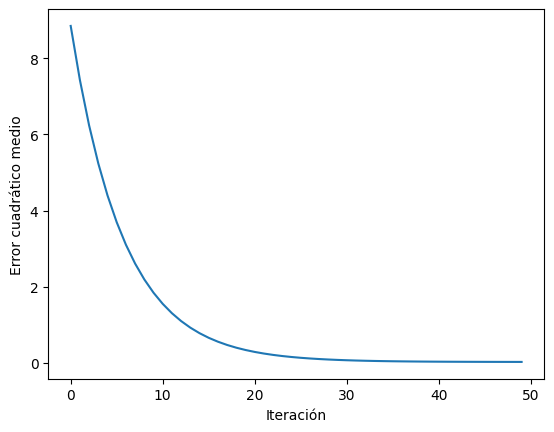

In [12]:
plt.plot(errores)
plt.xlabel(u'Iteración')
plt.ylabel(u'Error cuadrático medio')
plt.show()

## Descenso por gradiente estocástico

In [13]:
def descenso_gradiente_estocastico(X, y, t_lote = 8, n_iter = 10, alfa = 0.001):
  # Inicializamos parámetro con número aleatorio
  param = np.random.rand(X.shape[1], 1)

  n_lotes = int(X.shape[0] / t_lote)
  hist_error = []
  for it in range(n_iter):
    # Permutación aleatoria con la que se tomarán los lotes de la iteración
    perm = np.random.permutation(X.shape[0])
    for l in range(n_lotes):
      # Se toma el lote l-ésimo
      Xlote = X[perm[l * t_lote:(l + 1) * t_lote]]
      ylote = y[perm[l * t_lote:(l + 1) * t_lote]]

      # Obtenemos predicciones con parámetro actual
      y_pred = f(Xlote, param)

      # Actualizamos parámetro
      param = param - alfa * gradiente(Xlote, ylote, y_pred)

      hist_error.append(ecm(ylote, y_pred))

  return param, np.array(hist_error)

In [14]:
t_lote = 8
param_dge, errores = descenso_gradiente_estocastico(Xp_ent,
                                                    y_ent,
                                                    t_lote = t_lote,
                                                    n_iter = n_iter,
                                                    alfa = alfa)

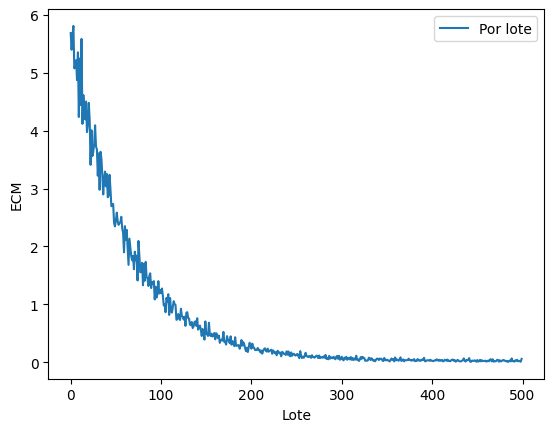

In [15]:
n_lotes = int(Xp_ent.shape[0] / t_lote)

plt.plot(errores.flatten(), label=u'Por lote')
plt.xlabel(u'Lote')
plt.ylabel(u'ECM')
plt.legend()
plt.show()

## Comparación con mínimos cuadrados

Comparamos los parámetros encontrados por mínimos cuadrados y usando el algoritmo del descenso por gradiente

In [16]:
param_mc = np.linalg.inv(Xp_ent.T @ Xp_ent) @ (Xp_ent.T @ y_ent)

print(f'MC = {param_mc.T}')
print(f'DG = {param_dg.T}')
print(f'DG = {param_dge.T}')

MC = [[3.15678571 0.44021645]]
DG = [[3.11999286 0.44358889]]
DG = [[3.1151567  0.44293147]]


Visualizamos las rectas con ambas soluciones

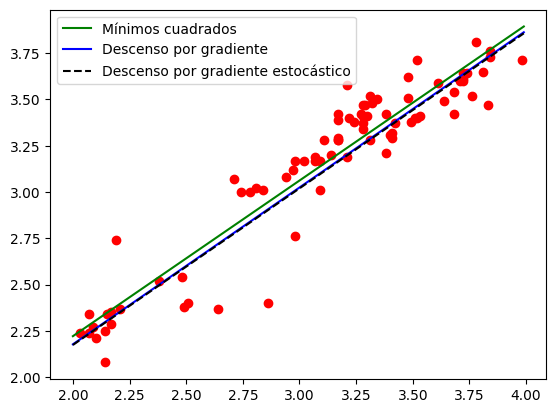

In [17]:
y_rango_dg = f(Xp_rango, param_dg)
y_rango_dge = f(Xp_rango, param_dge)
y_rango_mc = f(Xp_rango, param_mc)

plt.plot(Xp_ent[:, 1] * sigma + mu, y_ent[:, 0], 'ro')
plt.plot(Xp_rango[:, 1] * sigma + mu, y_rango_mc[:, 0], 'g', label='Mínimos cuadrados')
plt.plot(Xp_rango[:, 1] * sigma + mu, y_rango_dg[:, 0], 'b', label='Descenso por gradiente')
plt.plot(Xp_rango[:, 1] * sigma + mu, y_rango_dge[:, 0], 'k--', label='Descenso por gradiente estocástico')
plt.legend()
plt.show()

## Ejercicio
+ Programa y evalúa el algoritmo del descenso por gradiente para regresión lineal que minimice la siguiente función de error:

$$
E(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2\cdot n} \sum_{i = 1} ^n \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$